In [74]:
%matplotlib inline
import os
import ants
import numpy as np
import time
import nibabel as nib
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from glom_pop import dataio, alignment

#                   (Time series, associated anatomical series for this fly)
brain_file_sets = [
#                    ('TSeries-20210804-001', 'TSeries-20210804-003'),
#                    ('TSeries-20210804-002', 'TSeries-20210804-003'),
#                    ('TSeries-20210804-004', 'TSeries-20210804-006'),
#                    ('TSeries-20210804-005', 'TSeries-20210804-006'),
#                    ('TSeries-20210804-007', 'TSeries-20210804-009'),
#                    ('TSeries-20210804-008', 'TSeries-20210804-009'),
                   ('TSeries-20210811-001', 'TSeries-20210811-003'),
#                    ('TSeries-20210811-002', 'TSeries-20210811-003'),
#                    ('TSeries-20210811-004', 'TSeries-20210811-006'),
#                    ('TSeries-20210811-005', 'TSeries-20210811-006'),
#                    ('TSeries-20210811-007', 'TSeries-20210811-009'),
#                    ('TSeries-20210811-008', 'TSeries-20210811-009'),
                   ]

meanbrain_fn = 'chat_meanbrain_{}.nii'.format('20210824')

data_dir = '/oak/stanford/groups/trc/data/Max/ImagingData/Bruker'
base_dir = '/oak/stanford/groups/trc/data/Max/Analysis/glom_pop'
datafile_dir = '/oak/stanford/groups/trc/data/Max/ImagingData/DataFiles'

transform_directory = os.path.join(base_dir, 'transforms')

today = datetime.datetime.today().strftime('%Y%m%d')

In [75]:
def showBrain(brain, stride):
    """Quick display z slices of 2 channel brain."""
    num_slices = int(brain.shape[2]/stride)
    fh, ax = plt.subplots(2, num_slices, figsize=(num_slices*3, 4))
    [x.set_axis_off() for x in ax.ravel()]
    for z_ind in range(num_slices):
        ax[0, z_ind].imshow(ants.split_channels(brain)[0][:, :, z_ind*stride].T, cmap='Reds')
        ax[1, z_ind].imshow(ants.split_channels(brain)[1][:, :, z_ind*stride].T, cmap='Greens')


In [76]:

meanbrain = ants.image_read(os.path.join(base_dir, 'anatomical_brains', meanbrain_fn))
[meanbrain_red, meanbrain_green] = ants.split_channels(meanbrain)

# load transformed atlas and mask
fp_mask = os.path.join(transform_directory, 'meanbrain_template', 'glom_mask_reg2meanbrain.nii')
glom_mask_2_meanbrain = ants.image_read(fp_mask).numpy()

# # Load glom map, in meanbrain space
# mask_fp = os.path.join(base_dir, 'aligned', 'glom_mask_reg2meanbrain.nii')
# glom_mask_2_meanbrain = np.asanyarray(nib.load(mask_fp).dataobj).astype('uint32')

# Load mask key for VPN types
vpn_types = pd.read_csv(os.path.join(base_dir, 'template_brain', 'vpn_types.csv'))
# Filter glom map s.t. only big gloms are included
glom_size_threshold = 350
glom_mask_2_meanbrain = alignment.filterGlomMask(glom_mask_2_meanbrain, glom_size_threshold)
vals = np.unique(glom_mask_2_meanbrain)[1:]  # exclude first val (=0, not a glom)
names = vpn_types.loc[vpn_types.get('Unnamed: 0').isin(vals), 'vpn_types']

# convert back to ants image
glom_mask_2_meanbrain = ants.from_numpy(glom_mask_2_meanbrain, spacing=meanbrain_red.spacing)


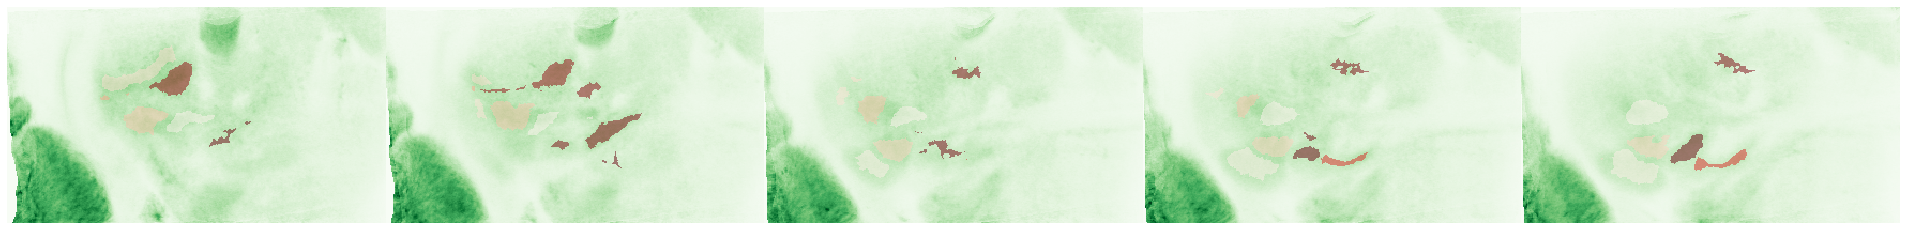

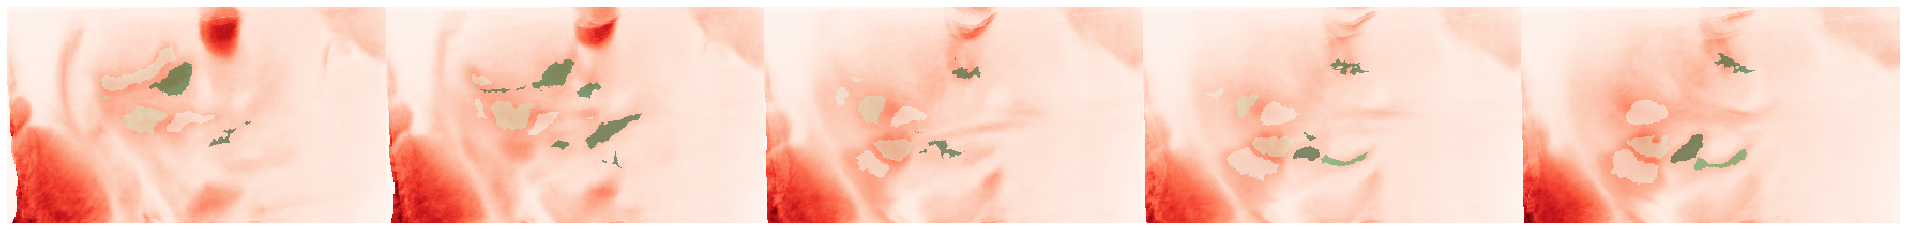

In [77]:
slices = [10, 20, 30, 35, 40]
ants.plot(image=meanbrain_green, cmap='Greens', alpha=0.5,
          overlay=glom_mask_2_meanbrain, overlay_cmap='Reds', overlay_alpha=0.5,
          axis=2, slices=slices, reorient=False, figsize=3, bg_val_quant=1.0, scale=False)

ants.plot(image=meanbrain_red, cmap='Reds', alpha=0.5,
          overlay=glom_mask_2_meanbrain, overlay_cmap='Greens', overlay_alpha=0.5,
          axis=2, slices=slices, reorient=False, figsize=3, bg_val_quant=1.0, scale=False)

In [78]:
bf = brain_file_sets[0]
functional_fn = bf[0]
anatomical_fn = bf[1]
overall_t0 = time.time()
print('Starting brain from {}'.format(functional_fn))

date_str = functional_fn.split('-')[1]
experiment_file_name = '{}-{}-{}'.format(date_str[0:4], date_str[4:6], date_str[6:8])
h5_filepath = os.path.join(datafile_dir, experiment_file_name + '.hdf5')
series_number = int(functional_fn.split('-')[-1])

# # # Load anatomical scan # # #
anat_filepath = os.path.join(base_dir, 'anatomical_brains', anatomical_fn + '_anatomical.nii')
red_brain = ants.split_channels(ants.image_read(anat_filepath))[0]
green_brain = ants.split_channels(ants.image_read(anat_filepath))[1]

Starting brain from TSeries-20210811-001


In [79]:
transform_dir = os.path.join(transform_directory, 'meanbrain_anatomical', anatomical_fn)
transform_list = dataio.get_transform_list(transform_dir, direction='inverse')

In [80]:
glom_mask_2_anat = ants.apply_transforms(fixed=red_brain,
                                         moving=glom_mask_2_meanbrain,
                                         transformlist=transform_list,
                                         interpolator='genericLabel',
                                         defaultvalue=0)

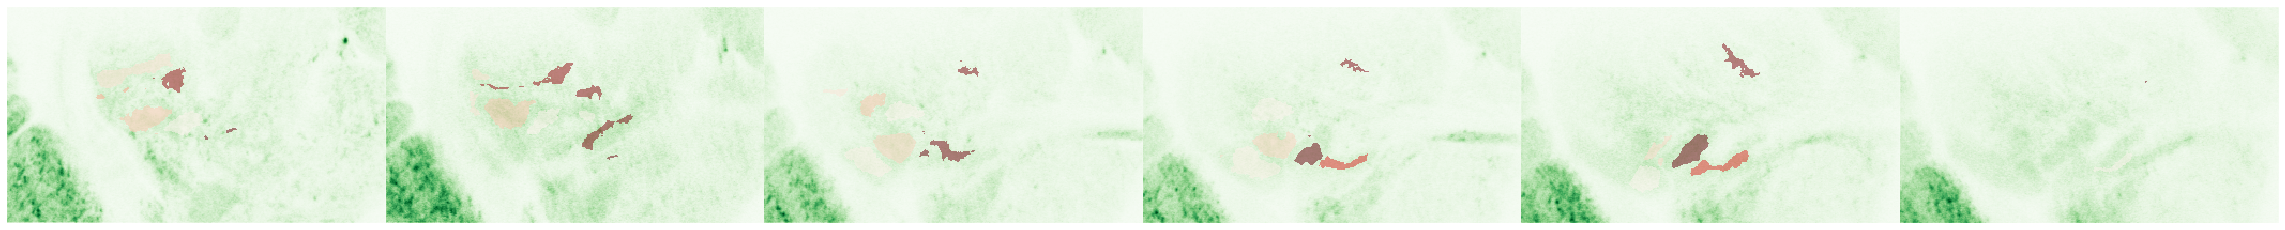

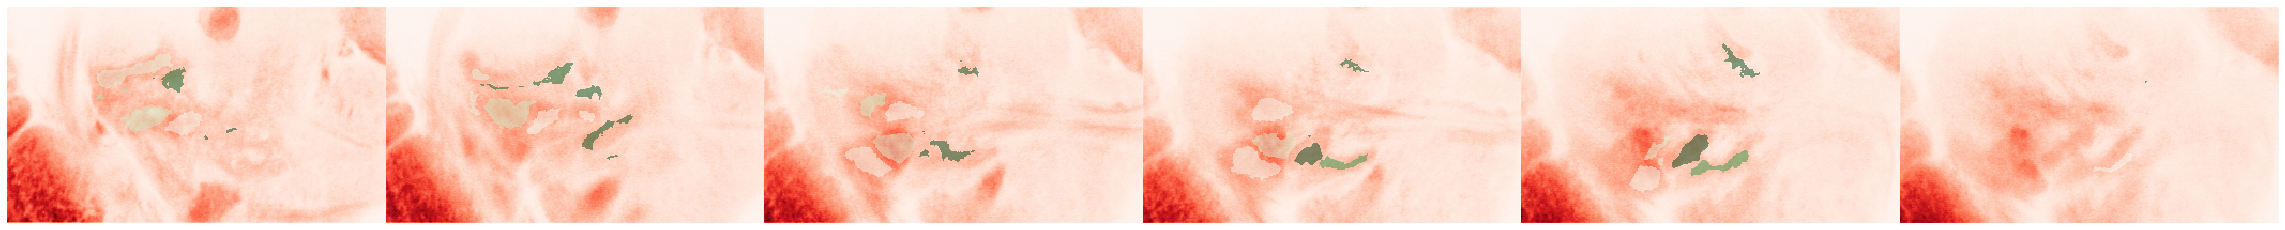

In [82]:
slices = [5, 10, 20, 30, 35, 40, 43]
ants.plot(image=green_brain, cmap='Greens', alpha=0.5,
          overlay=glom_mask_2_anat, overlay_cmap='Reds', overlay_alpha=0.5,
          axis=2, slices=slices, reorient=False, figsize=3, bg_val_quant=1.0, scale=False)

ants.plot(image=red_brain, cmap='Reds', alpha=0.5,
          overlay=glom_mask_2_anat, overlay_cmap='Greens', overlay_alpha=0.5,
          axis=2, slices=slices, reorient=False, figsize=3, bg_val_quant=1.0, scale=False)

In [83]:
fxn_filepath = os.path.join(data_dir, date_str, functional_fn)
fxn_filepath

'/oak/stanford/groups/trc/data/Max/ImagingData/Bruker/20210811/TSeries-20210811-001'

In [84]:
metadata_fxn = dataio.get_bruker_metadata(fxn_filepath + '.xml')
    
spacing = [float(metadata_fxn.get('micronsPerPixel_XAxis', 0)),
           float(metadata_fxn.get('micronsPerPixel_YAxis', 0)),
           float(metadata_fxn.get('micronsPerPixel_ZAxis', 0))]
nib_brain = np.asanyarray(nib.load(fxn_filepath + '_reg.nii').dataobj).mean(axis=3)
fxn_red = ants.from_numpy(nib_brain[:, :, :, 0], spacing=spacing)  # xyz
fxn_green = ants.from_numpy(nib_brain[:, :, :, 1], spacing=spacing)  # xyz

In [85]:
fxn_green

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (177, 101, 12)
	 Spacing    : (1.0004, 1.0004, 4.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [86]:
t0 = time.time()
reg_FA = ants.registration(fxn_red,
                           red_brain,
                           type_of_transform='Rigid',  # Within-animal, rigid reg is OK
                           flow_sigma=3,
                           total_sigma=0)

# # # Apply inverse transform to glom mask # # #
glom_mask_2_fxn = ants.apply_transforms(fixed=fxn_red,
                                        moving=glom_mask_2_anat,
                                        transformlist=reg_FA['fwdtransforms'],
                                        interpolator='genericLabel',
                                        defaultvalue=0)


anat_2_fxn = ants.apply_transforms(fixed=fxn_red,
                                        moving=red_brain,
                                        transformlist=reg_FA['fwdtransforms'],
                                        interpolator='genericLabel',
                                        defaultvalue=0)
print('Computed transform from ANAT -> FXN & applied to glom mask ({:.1f} sec)'.format(time.time()-t0))

Computed transform from ANAT -> FXN & applied to glom mask (10.4 sec)


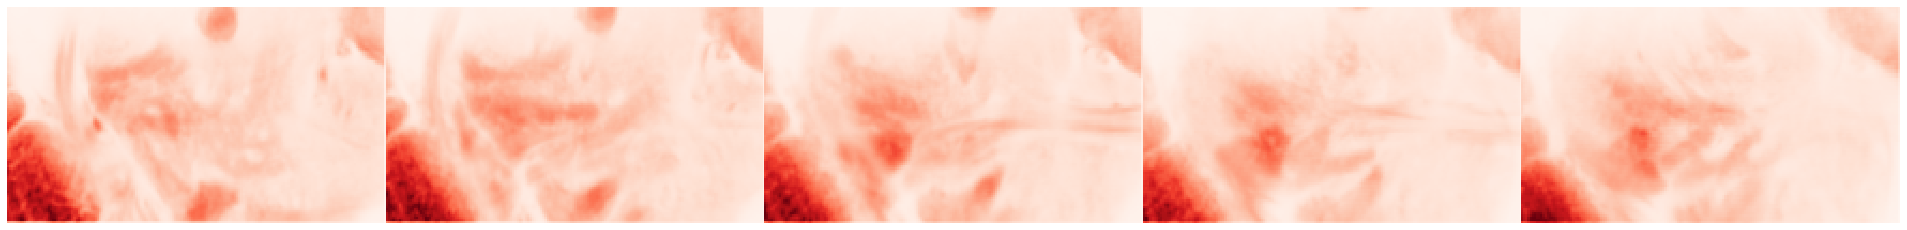

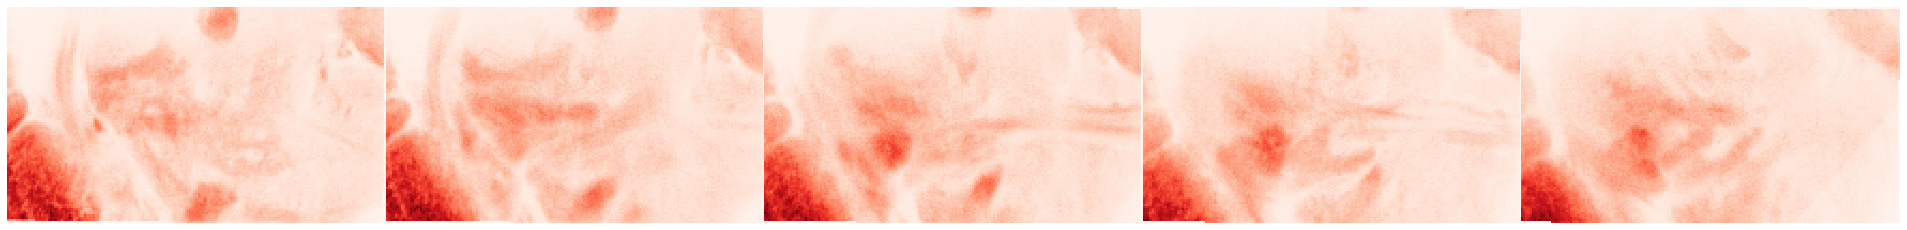

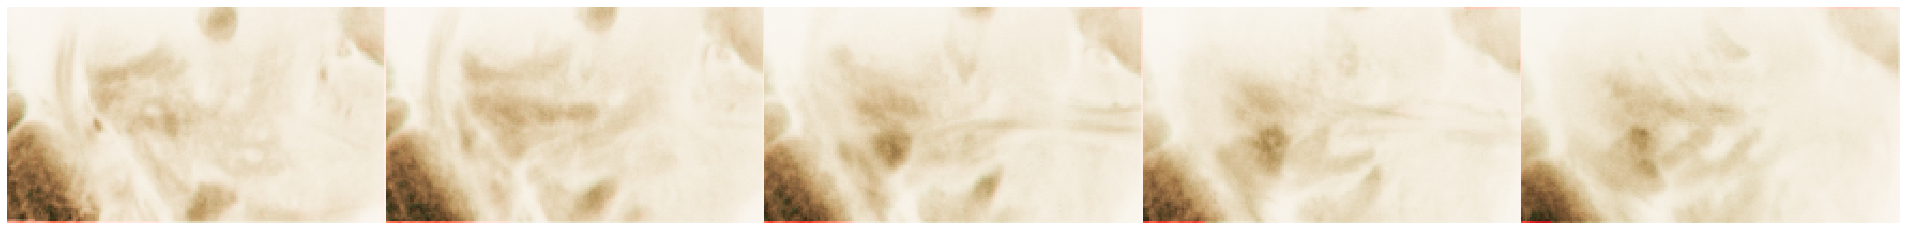

In [89]:
slices = [2, 4, 6, 8, 10]
ants.plot(image=fxn_red, cmap='Reds', alpha=0.5,
          axis=2, slices=slices, reorient=False, figsize=3, bg_val_quant=1.0, scale=False)

ants.plot(image=anat_2_fxn, cmap='Reds', alpha=0.5,
          axis=2, slices=slices, reorient=False, figsize=3, bg_val_quant=1.0, scale=False)

ants.plot(image=fxn_red, cmap='Reds', alpha=0.5,
          overlay=anat_2_fxn, overlay_cmap='Greens', overlay_alpha=0.5,
          axis=2, slices=slices, reorient=False, figsize=3, bg_val_quant=1.0, scale=False)

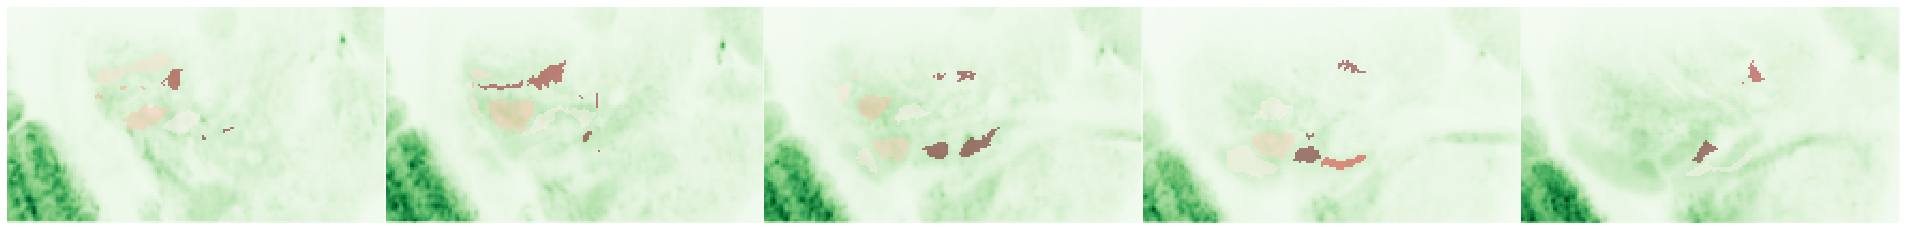

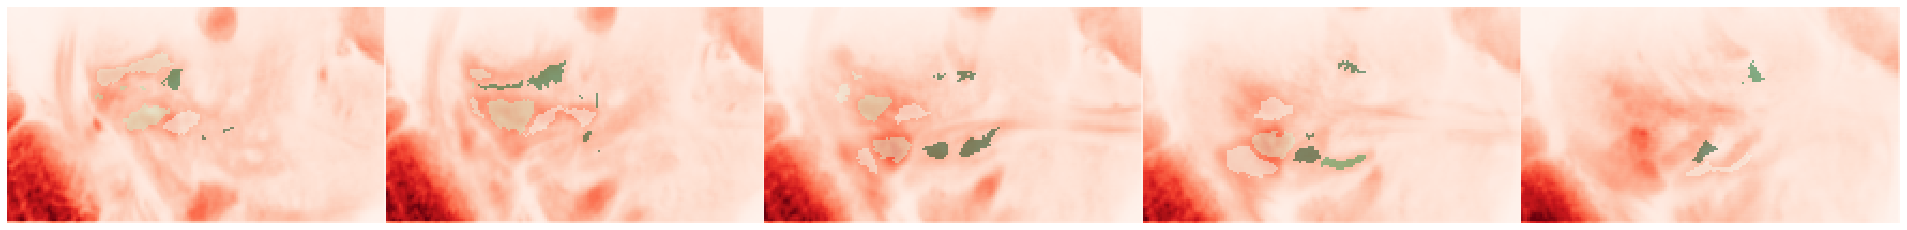

In [90]:
slices = [2, 4, 6, 8, 10]
ants.plot(image=fxn_green, cmap='Greens', alpha=0.5,
          overlay=glom_mask_2_fxn, overlay_cmap='Reds', overlay_alpha=0.5,
          axis=2, slices=slices, reorient=False, figsize=3, bg_val_quant=1.0, scale=False)

ants.plot(image=fxn_red, cmap='Reds', alpha=0.5,
          overlay=glom_mask_2_fxn, overlay_cmap='Greens', overlay_alpha=0.5,
          axis=2, slices=slices, reorient=False, figsize=3, bg_val_quant=1.0, scale=False)



In [70]:
green_brain = np.asanyarray(nib.load(fxn_filepath + '_reg.nii').dataobj)[..., 1]

In [72]:
green_brain.shape

(177, 101, 12, 7039)

In [92]:
merged = ants.merge_channels([fxn_red, fxn_green, glom_mask_2_fxn])
save_path = os.path.join(base_dir, 'overlays', '{}_masked.nii'.format(functional_fn))
ants.image_write(merged, save_path)

In [93]:
merged

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 3
	 Dimensions : (177, 101, 12)
	 Spacing    : (1.0004, 1.0004, 4.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]